In [5]:
import keras
from keras.models import Sequential, Model, load_model

from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D, LSTM, ConvLSTM2D, GRU, BatchNormalization, LocallyConnected2D, Permute
from keras.layers import Concatenate, Reshape, Softmax, Conv2DTranspose, Embedding, Multiply
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from keras import regularizers
from keras import backend as K
import keras.losses

import tensorflow as tf
from tensorflow.python.framework import ops

import isolearn.keras as iso

import numpy as np

import tensorflow as tf
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

import pandas as pd

import os
import pickle
import numpy as np

import scipy.sparse as sp
import scipy.io as spio

import matplotlib.pyplot as plt

import isolearn.io as isoio
import isolearn.keras as isol

from genesis.visualization import *
from genesis.generator import *
from genesis.predictor import *
from genesis.optimizer import *

from definitions.generator.splirent_deconv_conv_generator_concat import load_generator_network
from definitions.predictor.splirent_only_random_regions import load_saved_predictor

import sklearn
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from scipy.stats import pearsonr

import seaborn as sns
#sns.set()

from sklearn.neighbors import KNeighborsRegressor


In [2]:

#Define target isoform loss function
def get_isoform_loss(target_isos, region_1_start=10, region_1_end=35, region_1_target_bits=1.8, region_2_start=53, region_2_end=78, region_2_target_bits=1.8, entropy_weight=0.0, similarity_weight=0.0, similarity_margin=0.5) :
    
    target_iso = np.zeros((len(target_isos), 1))
    for i, t_iso in enumerate(target_isos) :
        target_iso[i, 0] = t_iso
    
    masked_entropy_mse_region_1 = get_target_entropy_sme_masked(pwm_start=region_1_start, pwm_end=region_1_end, target_bits=region_1_target_bits)
    masked_entropy_mse_region_2 = get_target_entropy_sme_masked(pwm_start=region_2_start, pwm_end=region_2_end, target_bits=region_2_target_bits)
    
    pwm_sample_entropy_func_region_1 = get_pwm_margin_sample_entropy_masked(pwm_start=region_1_start, pwm_end=region_1_end, margin=similarity_margin, shift_1_nt=True)
    pwm_sample_entropy_func_region_2 = get_pwm_margin_sample_entropy_masked(pwm_start=region_2_start, pwm_end=region_2_end, margin=similarity_margin, shift_1_nt=True)
    
    def loss_func(loss_tensors) :
        _, _, _, sequence_class, pwm_logits_1, pwm_logits_2, pwm_1, pwm_2, sampled_pwm_1, sampled_pwm_2, mask, sampled_mask, hek_pred, hela_pred, mcf7_pred, cho_pred = loss_tensors
        
        #Create target isoform with sample axis
        iso_targets = K.constant(target_iso)
        iso_true = K.gather(iso_targets, sequence_class[:, 0])
        iso_true = K.tile(K.expand_dims(iso_true, axis=-1), (1, K.shape(sampled_pwm_1)[1], 1))
        
        #Specify costs
        iso_loss = 2.0 * K.mean(symmetric_sigmoid_kl_divergence(iso_true, hek_pred), axis=1)
        
        seq_loss = 0.0
        
        entropy_loss = entropy_weight * (masked_entropy_mse_region_1(pwm_1, mask) + masked_entropy_mse_region_2(pwm_1, mask)) / 2.
        entropy_loss += similarity_weight * (K.mean(pwm_sample_entropy_func_region_1(sampled_pwm_1, sampled_pwm_2, sampled_mask), axis=1) + K.mean(pwm_sample_entropy_func_region_2(sampled_pwm_1, sampled_pwm_2, sampled_mask), axis=1)) / 2.
        
        #Compute total loss
        total_loss = iso_loss + seq_loss + entropy_loss

        return total_loss
    
    return loss_func

class EpochVariableCallback(Callback):
    def __init__(self, my_variable, my_func):
        self.my_variable = my_variable       
        self.my_func = my_func
    def on_epoch_end(self, epoch, logs={}):
        K.set_value(self.my_variable, self.my_func(K.get_value(self.my_variable), epoch))

#Function for running GENESIS
def run_genesis(sequence_templates, loss_func, library_contexts, model_path, batch_size=32, n_samples=1, n_epochs=10, steps_per_epoch=100) :
    
    #Build Generator Network
    _, generator = build_generator(batch_size, len(sequence_templates[0]), load_generator_network, n_classes=len(sequence_templates), n_samples=n_samples, sequence_templates=sequence_templates, batch_normalize_pwm=False)

    #Build Predictor Network and hook it on the generator PWM output tensor
    _, pwm_predictor = build_predictor(generator, load_saved_predictor(model_path, library_contexts=library_contexts), batch_size, n_samples=1, eval_mode='pwm')
    _, sample_predictor = build_predictor(generator, load_saved_predictor(model_path, library_contexts=library_contexts), batch_size, n_samples=n_samples, eval_mode='sample')

    for layer in pwm_predictor.layers :
        if 'splirent' in layer.name :
            layer.name += "_pwmversion"
    
    #Build Loss Model (In: Generator seed, Out: Loss function)
    _, pwm_loss_model = build_loss_model(pwm_predictor, loss_func)
    _, sample_loss_model = build_loss_model(sample_predictor, loss_func)
    
    dual_loss_out = Lambda(lambda x: 0.5 * x[0] + 0.5 * x[1])([pwm_loss_model.outputs[0], sample_loss_model.outputs[0]])

    loss_model = Model(inputs=pwm_loss_model.inputs, outputs=dual_loss_out)
    
    #Specify Optimizer to use
    #opt = keras.optimizers.SGD(lr=0.1)
    opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

    #Compile Loss Model (Minimize self)
    loss_model.compile(loss=lambda true, pred: pred, optimizer=opt)

    #Fit Loss Model
    train_history = loss_model.fit(
        [], np.ones((1, 1)),
        epochs=n_epochs,
        steps_per_epoch=steps_per_epoch
    )

    return generator, sample_predictor, train_history



In [3]:
#Specfiy file path to pre-trained predictor network

save_dir = os.path.join(os.getcwd(), '../../../splirent/saved_models')
saved_predictor_model_name = 'aparent_splirent_only_random_regions_drop_02_sgd.h5'
saved_predictor_model_path = os.path.join(save_dir, saved_predictor_model_name)

In [4]:
#Optimize isoform proportions according to target

sequence_templates = [
    'AGGTGCTTGGNNNNNNNNNNNNNNNNNNNNNNNNNGGTCGACCCAGGTTCGTGNNNNNNNNNNNNNNNNNNNNNNNNNGAGGTATTCTTATCACCTTCGTGGCTACAGA',
    'AGGTGCTTGGNNNNNNNNNNNNNNNNNNNNNNNNNGGTCGACCCAGGTTCGTGNNNNNNNNNNNNNNNNNNNNNNNNNGAGGTATTCTTATCACCTTCGTGGCTACAGA',
    'AGGTGCTTGGNNNNNNNNNNNNNNNNNNNNNNNNNGGTCGACCCAGGTTCGTGNNNNNNNNNNNNNNNNNNNNNNNNNGAGGTATTCTTATCACCTTCGTGGCTACAGA',
    'AGGTGCTTGGNNNNNNNNNNNNNNNNNNNNNNNNNGGTCGACCCAGGTTCGTGNNNNNNNNNNNNNNNNNNNNNNNNNGAGGTATTCTTATCACCTTCGTGGCTACAGA',
    'AGGTGCTTGGNNNNNNNNNNNNNNNNNNNNNNNNNGGTCGACCCAGGTTCGTGNNNNNNNNNNNNNNNNNNNNNNNNNGAGGTATTCTTATCACCTTCGTGGCTACAGA'
]

library_contexts = [
    'n/a',
    'n/a',
    'n/a',
    'n/a',
    'n/a'
]

target_isos = [
    0.00,
    0.25,
    0.5,
    0.75,
    1.0
]


save_name_suffixes = [
    'hek',
    'hek',
    'hek',
    'hek',
    'hek'
]


In [ ]:
#Train Splicing GENESIS Network

print("Training GENESIS (Targeted Splicing)")

#Number of PWMs to generate per objective
batch_size = 32
#Number of One-hot sequences to sample from the PWM at each grad step
n_samples = 10
#Number of epochs per objective to optimize
n_epochs = 50
#Number of steps (grad updates) per epoch
steps_per_epoch = 500

for class_i in range(len(sequence_templates)) :
    print("Target iso = " + str(target_isos[class_i]))
    
    lib_name = library_contexts[class_i].split("_")[0]
    print("Library context = " + str(lib_name))
    
    save_name_suffix = save_name_suffixes[class_i]
    print("Save suffix = " + str(save_name_suffix))
    
    K.clear_session()
    
    loss = get_isoform_loss(
        [target_isos[class_i]],
        region_1_start=10,
        region_1_end=35,
        region_1_target_bits=2.0,
        region_2_start=53,
        region_2_end=78,
        region_2_target_bits=2.0,
        entropy_weight=3.5,#2.0,#1.0,
        similarity_weight=7.5,#5.0,
        similarity_margin=0.5
    )

    genesis_generator, genesis_predictor, train_history = run_genesis([sequence_templates[class_i]], loss, [library_contexts[class_i]], saved_predictor_model_path, batch_size, n_samples, n_epochs, steps_per_epoch)

    genesis_generator.get_layer('lambda_rand_sequence_class').function = lambda inp: inp
    genesis_generator.get_layer('lambda_rand_input_1').function = lambda inp: inp
    genesis_generator.get_layer('lambda_rand_input_2').function = lambda inp: inp

    genesis_predictor.get_layer('lambda_rand_sequence_class').function = lambda inp: inp
    genesis_predictor.get_layer('lambda_rand_input_1').function = lambda inp: inp
    genesis_predictor.get_layer('lambda_rand_input_2').function = lambda inp: inp

    # Save model and weights
    save_dir = 'saved_models'

    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
    
    model_name = 'genesis_splicing_cnn_target_isoform_' + str(target_isos[class_i]).replace(".", "") + '_pwm_and_multisample_' + save_name_suffix + '_only_random_regions_' + str(n_epochs) + '_epochs_harderentropy_generator.h5'
    model_path = os.path.join(save_dir, model_name)
    genesis_generator.save(model_path)
    print('Saved trained model at %s ' % model_path)

    model_name = 'genesis_splicing_cnn_target_isoform_' + str(target_isos[class_i]).replace(".", "") + '_pwm_and_multisample_' + save_name_suffix + '_only_random_regions_' + str(n_epochs) + '_epochs_harderentropy_predictor.h5'
    model_path = os.path.join(save_dir, model_name)
    genesis_predictor.save(model_path)
    print('Saved trained model at %s ' % model_path)
    

In [2]:
#Specfiy file path to pre-trained predictor network

save_dir = os.path.join(os.getcwd(), '../../../splirent/saved_models')
saved_predictor_model_name = 'aparent_splirent_only_random_regions_drop_02_sgd.h5'
saved_predictor_model_path = os.path.join(save_dir, saved_predictor_model_name)

Target iso = 1.0


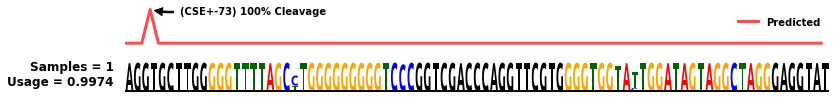

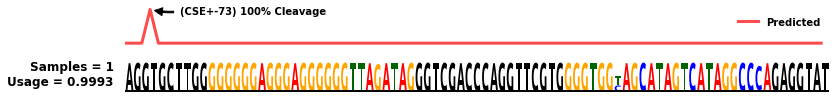

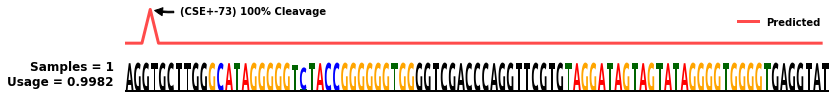

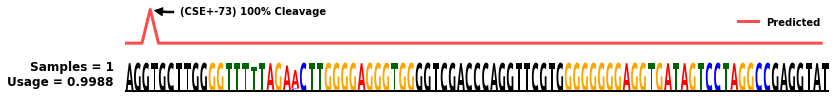

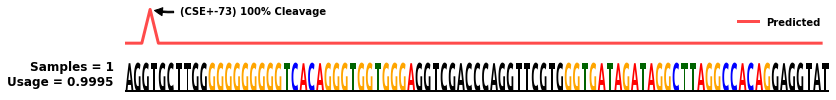

Target iso = 0.75


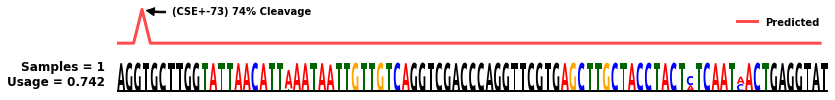

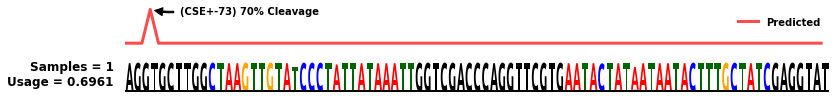

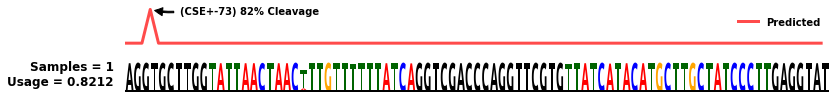

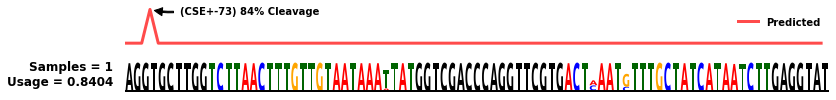

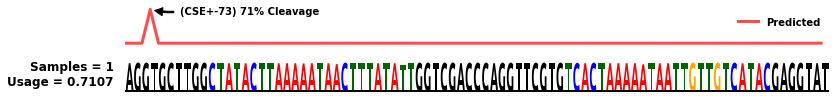

Target iso = 0.5


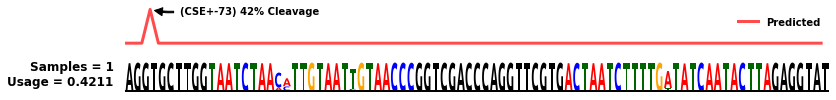

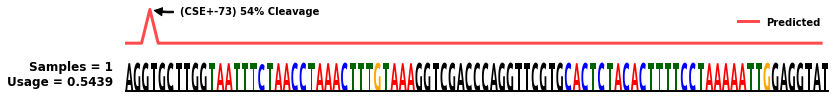

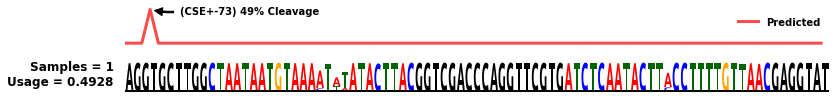

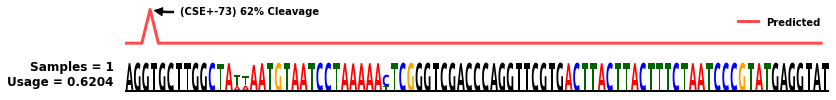

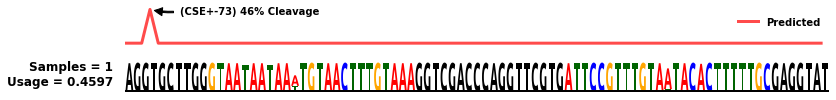

Target iso = 0.25


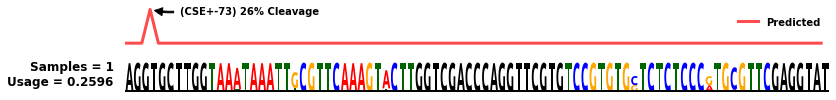

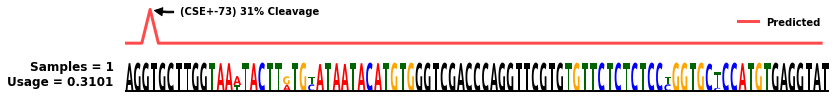

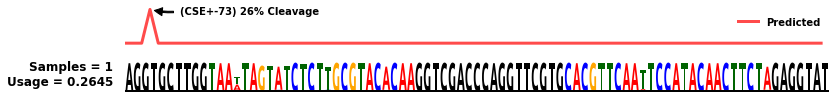

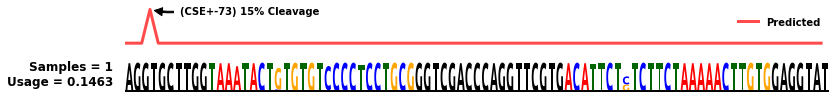

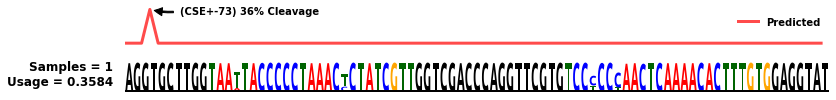

Target iso = 0.0


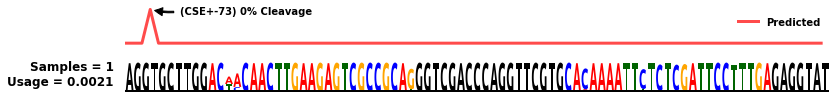

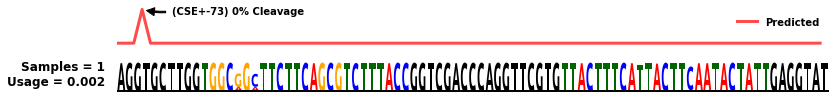

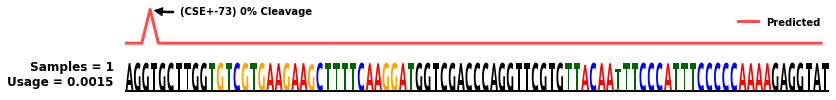

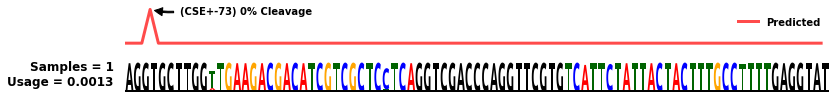

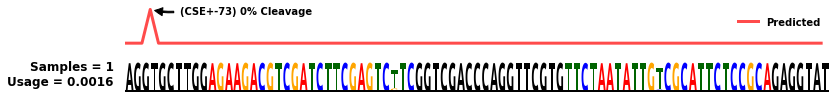

In [8]:
#Load GENESIS models and predict sample sequences

model_names = [
    'genesis_splicing_cnn_target_isoform_00_pwm_and_multisample_hek_only_random_regions_50_epochs_harderentropy',
    'genesis_splicing_cnn_target_isoform_025_pwm_and_multisample_hek_only_random_regions_50_epochs_harderentropy',
    'genesis_splicing_cnn_target_isoform_05_pwm_and_multisample_hek_only_random_regions_50_epochs_harderentropy',
    'genesis_splicing_cnn_target_isoform_075_pwm_and_multisample_hek_only_random_regions_50_epochs_harderentropy',
    'genesis_splicing_cnn_target_isoform_10_pwm_and_multisample_hek_only_random_regions_70_epochs_harderentropy',
]

sequence_templates = [
    'AGGTGCTTGGNNNNNNNNNNNNNNNNNNNNNNNNNGGTCGACCCAGGTTCGTGNNNNNNNNNNNNNNNNNNNNNNNNNGAGGTATTCTTATCACCTTCGTGGCTACAGA',
    'AGGTGCTTGGNNNNNNNNNNNNNNNNNNNNNNNNNGGTCGACCCAGGTTCGTGNNNNNNNNNNNNNNNNNNNNNNNNNGAGGTATTCTTATCACCTTCGTGGCTACAGA',
    'AGGTGCTTGGNNNNNNNNNNNNNNNNNNNNNNNNNGGTCGACCCAGGTTCGTGNNNNNNNNNNNNNNNNNNNNNNNNNGAGGTATTCTTATCACCTTCGTGGCTACAGA',
    'AGGTGCTTGGNNNNNNNNNNNNNNNNNNNNNNNNNGGTCGACCCAGGTTCGTGNNNNNNNNNNNNNNNNNNNNNNNNNGAGGTATTCTTATCACCTTCGTGGCTACAGA',
    'AGGTGCTTGGNNNNNNNNNNNNNNNNNNNNNNNNNGGTCGACCCAGGTTCGTGNNNNNNNNNNNNNNNNNNNNNNNNNGAGGTATTCTTATCACCTTCGTGGCTACAGA'
]

library_contexts = [
    'n/a',
    'n/a',
    'n/a',
    'n/a',
    'n/a'
]

target_isos = [
    0.00,
    0.25,
    0.5,
    0.75,
    1.0
]


save_name_suffixes = [
    'hek',
    'hek',
    'hek',
    'hek',
    'hek'
]

for class_i in range(len(sequence_templates)-1, 0-1, -1) :
    print("Target iso = " + str(target_isos[class_i]))
    
    save_dir = os.path.join(os.getcwd(), 'saved_models')
    model_name = model_names[class_i] + '_predictor.h5'
    model_path = os.path.join(save_dir, model_name)

    predictor = load_model(model_path, custom_objects={'st_sampled_softmax': st_sampled_softmax, 'st_hardmax_softmax': st_hardmax_softmax})
    
    n = 32

    sequence_class = np.array([0] * n).reshape(-1, 1) #np.random.uniform(-6, 6, (n, 1)) #

    noise_1 = np.random.uniform(-1, 1, (n, 100))
    noise_2 = np.random.uniform(-1, 1, (n, 100))

    pred_outputs = predictor.predict([sequence_class, noise_1, noise_2], batch_size=32)

    _, _, _, optimized_pwm, _, _, _, _, _, hek_pred, _, _, _ = pred_outputs
    
    for pwm_index in range(5) :

        sequence_template = sequence_templates[class_i]

        pwm = np.expand_dims(optimized_pwm[pwm_index, :, :, 0], axis=0)
        iso = np.expand_dims(hek_pred[pwm_index, 0], axis=0)
        cut = np.zeros((1, 109))
        cut[0, 3] = iso[0]

        plot_seqprop_logo(pwm, iso, cut, annotate_peaks='max', sequence_template=sequence_template, figsize=(12, 1.5), width_ratios=[1, 8], logo_height=0.8, usage_unit='fraction', plot_start=0, plot_end=85, save_figs=False, fig_name='splicing_target_isoform_genesis_' + str(target_isos[class_i]).replace(".", "") + "_pwm_index_" + str(pwm_index), fig_dpi=150)




In [10]:

model_names = [
    'genesis_splicing_cnn_target_isoform_00_pwm_and_multisample_hek_only_random_regions_50_epochs_harderentropy',
    'genesis_splicing_cnn_target_isoform_025_pwm_and_multisample_hek_only_random_regions_50_epochs_harderentropy',
    'genesis_splicing_cnn_target_isoform_05_pwm_and_multisample_hek_only_random_regions_50_epochs_harderentropy',
    'genesis_splicing_cnn_target_isoform_075_pwm_and_multisample_hek_only_random_regions_50_epochs_harderentropy',
    'genesis_splicing_cnn_target_isoform_10_pwm_and_multisample_hek_only_random_regions_70_epochs_harderentropy',
]

sequence_templates = [
    'AGGTGCTTGGNNNNNNNNNNNNNNNNNNNNNNNNNGGTCGACCCAGGTTCGTGNNNNNNNNNNNNNNNNNNNNNNNNNGAGGTATTCTTATCACCTTCGTGGCTACAGA',
    'AGGTGCTTGGNNNNNNNNNNNNNNNNNNNNNNNNNGGTCGACCCAGGTTCGTGNNNNNNNNNNNNNNNNNNNNNNNNNGAGGTATTCTTATCACCTTCGTGGCTACAGA',
    'AGGTGCTTGGNNNNNNNNNNNNNNNNNNNNNNNNNGGTCGACCCAGGTTCGTGNNNNNNNNNNNNNNNNNNNNNNNNNGAGGTATTCTTATCACCTTCGTGGCTACAGA',
    'AGGTGCTTGGNNNNNNNNNNNNNNNNNNNNNNNNNGGTCGACCCAGGTTCGTGNNNNNNNNNNNNNNNNNNNNNNNNNGAGGTATTCTTATCACCTTCGTGGCTACAGA',
    'AGGTGCTTGGNNNNNNNNNNNNNNNNNNNNNNNNNGGTCGACCCAGGTTCGTGNNNNNNNNNNNNNNNNNNNNNNNNNGAGGTATTCTTATCACCTTCGTGGCTACAGA'
]

library_contexts = [
    'n/a',
    'n/a',
    'n/a',
    'n/a',
    'n/a'
]

target_isos = [
    0.00,
    0.25,
    0.5,
    0.75,
    1.0
]

n_classes = 5


In [24]:
#Helper function to get the conensus sequence from a PWM
def get_consensus_sequence(pwm) :
    consensus = ''
    
    for j in range(pwm.shape[0]) :
        nt_ix = np.argmax(pwm[j, :])
        
        if nt_ix == 0 :
            consensus += 'A'
        elif nt_ix == 1 :
            consensus += 'C'
        elif nt_ix == 2 :
            consensus += 'G'
        elif nt_ix == 3 :
            consensus += 'T'
    
    return consensus


n_sequences = 1000
n_sequences_ceil = int(n_sequences / 32) * 32 + 32

pwms = []
consensus_seqs = []
onehot_seqs = []
iso_preds = []
objectives = []

onehot_encoder = isol.OneHotEncoder(109)

for k in range(n_classes) :
    print('Predicting sequences for objective ' + str(k) + '...')
    
    save_dir = os.path.join(os.getcwd(), 'saved_models')
    model_name = model_names[k] + '_predictor.h5'
    model_path = os.path.join(save_dir, model_name)

    predictor = load_model(model_path, custom_objects={'st_sampled_softmax': st_sampled_softmax, 'st_hardmax_softmax': st_hardmax_softmax})
    
    
    
    sequence_class = np.tile(np.array([[0]]), (n_sequences_ceil, 1))
    
    noise_1 = np.random.uniform(-1, 1, (n_sequences_ceil, 100))
    noise_2 = np.random.uniform(-1, 1, (n_sequences_ceil, 100))
    
    pred_outputs = predictor.predict([sequence_class, noise_1, noise_2], batch_size=32)
    _, _, _, optimized_pwm, _, _, _, _, _, hek_pred, _, _, _ = pred_outputs

    optimized_pwm = np.expand_dims(optimized_pwm[:n_sequences, :, :, 0], axis=0)
    iso_pred = hek_pred[:n_sequences, 0, 0]
    
    iso_pred = np.expand_dims(iso_pred, axis=0)
    
    pwms.append(optimized_pwm)
    iso_preds.append(iso_pred)
    
    consensus_seqs.append([])
    onehot_seqs.append([])
    for i in range(n_sequences) :
        consensus_seqs[k].append(get_consensus_sequence(optimized_pwm[0, i, :, :]))
        onehot_seqs[k].append(onehot_encoder(get_consensus_sequence(optimized_pwm[0, i, :, :])))
    
    consensus_seqs[k] = np.expand_dims(np.array(consensus_seqs[k], dtype=np.object), axis=0)
    onehot_seqs[k] = np.expand_dims(onehot_seqs[k], axis=0)
    
    objectives.append(np.zeros((1, n_sequences)) + k)

pwms = np.concatenate(pwms, axis=0)
iso_preds = np.concatenate(iso_preds, axis=0)
consensus_seqs = np.concatenate(consensus_seqs, axis=0)
onehot_seqs = np.concatenate(onehot_seqs, axis=0)
objectives = np.concatenate(objectives, axis=0)

print('pwms.shape = ' + str(pwms.shape))
print('iso_preds.shape = ' + str(iso_preds.shape))
print('consensus_seqs.shape = ' + str(consensus_seqs.shape))
print('onehot_seqs.shape = ' + str(onehot_seqs.shape))
print('objectives.shape = ' + str(objectives.shape))

Predicting sequences for objective 0...


/home/johli/anaconda3/envs/aparent/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Predicting sequences for objective 1...


/home/johli/anaconda3/envs/aparent/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Predicting sequences for objective 2...


/home/johli/anaconda3/envs/aparent/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Predicting sequences for objective 3...


/home/johli/anaconda3/envs/aparent/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Predicting sequences for objective 4...


/home/johli/anaconda3/envs/aparent/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


pwms.shape = (5, 1000, 109, 4)
iso_preds.shape = (5, 1000)
consensus_seqs.shape = (5, 1000)
onehot_seqs.shape = (5, 1000, 109, 4)
objectives.shape = (5, 1000)


In [12]:
#Specfiy file path to pre-trained predictor network

save_dir = os.path.join(os.getcwd(), '../../../splirent/saved_models')
saved_predictor_model_name = 'aparent_splirent_only_random_regions_drop_02_sgd.h5'
saved_predictor_model_path = os.path.join(save_dir, saved_predictor_model_name)

splirent_model = load_model(saved_predictor_model_path)

/home/johli/anaconda3/envs/aparent/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [26]:

#Create a new model that outputs the conv layer activation maps together with the isoform proportion
dense_out_model = Model(
    inputs = splirent_model.inputs,
    outputs = [
        splirent_model.get_layer('dropout_1').output
    ]
)


In [27]:
#Output dense layer activations for generated sequences

genesis_dense_outs = []

for k in range(onehot_seqs.shape[0]) :
    
    genesis_dense_out = dense_out_model.predict(x=[onehot_seqs[k][:, 5:40, :], onehot_seqs[k][:, 48:83, :]])

    print(genesis_dense_out.shape)
    
    genesis_dense_outs.append(np.expand_dims(genesis_dense_out, axis=0))

genesis_dense_outs = np.concatenate(genesis_dense_outs, axis=0)

print(genesis_dense_outs.shape)


(1000, 256)
(1000, 256)
(1000, 256)
(1000, 256)
(1000, 256)
(5, 1000, 256)


In [28]:

flat_onehot_seqs = np.reshape(onehot_seqs, (n_classes * n_sequences, 109 * 4))
flat_objectives = np.ravel(objectives)

class_targs = ['0.00', '0.25', '0.50', '0.75', '1.00']

flat_labels = np.array([class_targs[int(k)] for k in flat_objectives.tolist()], dtype=np.object)

flat_onehot_seqs_opt = flat_onehot_seqs[:, 10*4:78*4]

flat_dense_outs = np.reshape(genesis_dense_outs, (n_classes * n_sequences, 256))


n_unique_sequences = 1000


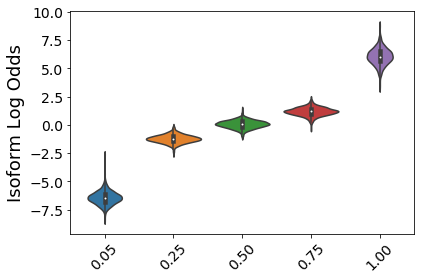

In [25]:

#Uniquely generated sequences per objective

unique_count = len(np.unique(consensus_seqs[0, :]))

print('n_unique_sequences = ' + str(unique_count))

save_figs = False

#Target vs. Engineered Isoform Log Odds

iso_props = [iso_preds[k, :] for k in range(n_classes)]
iso_logodds = [np.log(iso_preds[k, :] / (1.0 - iso_preds[k, :])) for k in range(n_classes)]

f = plt.figure(figsize=(6, 4))

sns.violinplot(data=iso_logodds, axis=0)

plt.xticks(np.arange(5), ['0.05', '0.25', '0.50', '0.75', '1.00'], fontsize=14, rotation=45)
plt.yticks(fontsize=14)

plt.ylabel('Isoform Log Odds', fontsize=18)

plt.tight_layout()

if save_figs :
    plt.savefig('splicing_target_isoform_genesis_doubledope_iso_magnitude.png', transparent=True, dpi=150)
    plt.savefig('splicing_target_isoform_genesis_doubledope_iso_magnitude.eps')
    plt.savefig('splicing_target_isoform_genesis_doubledope_iso_magnitude.svg')

plt.show()



In [30]:
import pickle

import isolearn.io as isoio
import isolearn.keras as iso

def iso_normalizer(t) :
    iso = 0.0
    if np.sum(t) > 0.0 :
        iso = t[0] / np.sum(t)
    
    return iso

def cut_normalizer(t) :
    cuts = np.concatenate([np.zeros(100), np.array([1.0])])
    if np.sum(t) > 0.0 :
        cuts = t / np.sum(t)
    
    return cuts


#Create nearest neighbor search database

#Load plasmid data
plasmid_dict = pickle.load(open('../../../splirent/data/a5ss/processed_data/' + 'alt_5ss_data.pickle', 'rb'))

valid_set_size = 10000
test_set_size = 10000

#Generate training and test set indexes
plasmid_index = np.arange(len(plasmid_dict['min_df']), dtype=np.int)

if valid_set_size < 1.0 and test_set_size < 1.0 :
    train_index = plasmid_index[:-int(len(plasmid_dict['min_df']) * (valid_set_size + test_set_size))]
    valid_index = plasmid_index[train_index.shape[0]:-int(len(plasmid_dict['min_df']) * test_set_size)]
    test_index = plasmid_index[train_index.shape[0] + valid_index.shape[0]:]
else :
    train_index = plasmid_index[:-int(valid_set_size + test_set_size)]
    valid_index = plasmid_index[train_index.shape[0]:-int(test_set_size)]
    test_index = plasmid_index[train_index.shape[0] + valid_index.shape[0]:]

print('Training set size = ' + str(train_index.shape[0]))
print('Validation set size = ' + str(valid_index.shape[0]))
print('Test set size = ' + str(test_index.shape[0]))


seq_start_1 = 147
seq_start_2 = 147 + 25 + 18
splice_donor_pos = 140

sequence_padding = 5

splicing_gens = {
    gen_id : iso.DataGenerator(
        idx,
        {
            'df' : plasmid_dict['min_df'],
            'hek_count' : plasmid_dict['min_hek_count'],
            'hela_count' : plasmid_dict['min_hela_count'],
            'mcf7_count' : plasmid_dict['min_mcf7_count'],
            'cho_count' : plasmid_dict['min_cho_count'],
        },
        batch_size=len(idx),#32,
        inputs = [
            {
                'id' : 'random_region_1',
                'source_type' : 'dataframe',
                'source' : 'df',
                'extractor' : lambda row, index, seq_start_1=seq_start_1, seq_start_2=seq_start_2, sequence_padding=sequence_padding: row['padded_seq'][seq_start_1 - sequence_padding: seq_start_1 + 25 + sequence_padding],
                'encoder' : iso.OneHotEncoder(seq_length=25 + 2 * sequence_padding),
                'dim' : (25 + 2 * sequence_padding, 4),
                'sparsify' : False
            },
            {
                'id' : 'random_region_2',
                'source_type' : 'dataframe',
                'source' : 'df',
                'extractor' : lambda row, index, seq_start_1=seq_start_1, seq_start_2=seq_start_2, sequence_padding=sequence_padding: row['padded_seq'][seq_start_2 - sequence_padding: seq_start_2 + 25 + sequence_padding],
                'encoder' : iso.OneHotEncoder(seq_length=25 + 2 * sequence_padding),
                'dim' : (25 + 2 * sequence_padding, 4),
                'sparsify' : False
            }
        ],
        outputs = [
            {
                'id' : cell_type + '_sd1_usage',
                'source_type' : 'matrix',
                'source' : cell_type + '_count',
                'extractor' : iso.CountExtractor(start_pos=splice_donor_pos, end_pos=splice_donor_pos + 100, static_poses=[-1], sparse_source=True),
                'transformer' : lambda t: iso_normalizer(t),
                'dim' : (1,)
            } for cell_type in ['hek', 'hela', 'mcf7', 'cho']
        ] + [
            {
                'id' : cell_type + '_count',
                'source_type' : 'matrix',
                'source' : cell_type + '_count',
                'extractor' : iso.CountExtractor(start_pos=splice_donor_pos, end_pos=splice_donor_pos + 100, static_poses=[-1], sparse_source=True),
                'transformer' : lambda t: np.sum(t),
                'dim' : (1,)
            } for cell_type in ['hek', 'hela', 'mcf7', 'cho']
        ],
        randomizers = [],
        shuffle = False,
        densify_batch_matrices=False,
    ) for gen_id, idx in [('all', plasmid_index), ('train', train_index), ('valid', valid_index), ('test', test_index)]
}


Training set size = 244647
Validation set size = 10000
Test set size = 10000


In [31]:

[onehots_up, onehots_dn], [hek_true, hela_true, mcf7_true, cho_true, hek_count, hela_count, mcf7_count, cho_count] = splicing_gens['all'][0]


In [36]:

#Filter dataset

keep_index = np.nonzero(hek_count >= 30)[0]

onehots_up_kept = onehots_up[keep_index]
onehots_dn_kept = onehots_dn[keep_index]

hek_true_kept = hek_true[keep_index]
hela_true_kept = hela_true[keep_index]
mcf7_true_kept = mcf7_true[keep_index]
cho_true_kept = cho_true[keep_index]

hek_count_kept = hek_count[keep_index]
hela_count_kept = hela_count[keep_index]
mcf7_count_kept = mcf7_count[keep_index]
cho_count_kept = cho_count[keep_index]


In [38]:
#Output dense layer activations for splicing MPRA

library_dense_out_kept = dense_out_model.predict(x=[onehots_up_kept, onehots_dn_kept], batch_size=32)

print(library_dense_out_kept.shape)


(193441, 256)


In [39]:
#Fit 10-NN Regressor on Splicing MPRA, predict on generated sequences

nn_dense_hek_10 = KNeighborsRegressor(n_neighbors=10).fit(library_dense_out_kept, hek_true_kept)

nn_iso = nn_dense_hek_10.predict(flat_dense_outs)


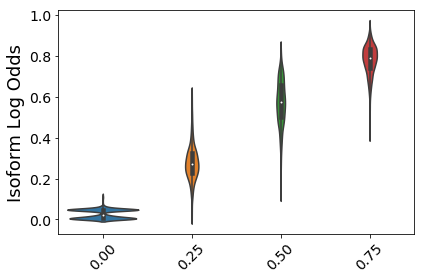

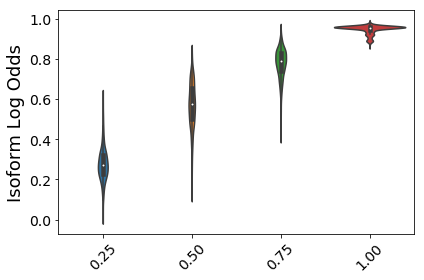

In [42]:

save_figs = False

#Target vs. Engineered Isoform Log Odds

nn_iso_clipped = np.clip(nn_iso, 0.001, 0.999)

nn_iso_by_class = [np.ravel(nn_iso_clipped)[flat_labels == lab] for lab in class_targs]
nn_logodds_by_class = [np.log(nn_iso_by_class[k] / (1.0 - nn_iso_by_class[k])) for k in range(len(nn_iso_by_class))]

f = plt.figure(figsize=(6, 4))

sns.violinplot(data=nn_iso_by_class[:4], axis=0)

#plt.xticks(np.arange(5), ['0.05', '0.25', '0.50', '0.75', '1.00'], fontsize=14, rotation=45)
plt.xticks(np.arange(4), ['0.00', '0.25', '0.50', '0.75'], fontsize=14, rotation=45)
plt.yticks(fontsize=14)

plt.ylabel('Isoform Log Odds', fontsize=18)

plt.tight_layout()

if save_figs :
    plt.savefig('splicing_target_isoform_genesis_nn_iso_magnitude.png', transparent=True, dpi=150)
    plt.savefig('splicing_target_isoform_genesis_nn_iso_magnitude.eps')
    plt.savefig('splicing_target_isoform_genesis_nn_iso_magnitude.svg')

plt.show()


f = plt.figure(figsize=(6, 4))

sns.violinplot(data=nn_iso_by_class[1:], axis=0)

plt.xticks(np.arange(4), ['0.25', '0.50', '0.75', '1.00'], fontsize=14, rotation=45)
plt.yticks(fontsize=14)

plt.ylabel('Isoform Log Odds', fontsize=18)

plt.tight_layout()

if save_figs :
    plt.savefig('splicing_max_isoform_genesis_nn_iso_magnitude.png', transparent=True, dpi=150)
    plt.savefig('splicing_max_isoform_genesis_nn_iso_magnitude.eps')
    plt.savefig('splicing_max_isoform_genesis_nn_iso_magnitude.svg')

plt.show()


In [43]:
#Fit 50-NN Regressor on Splicing MPRA, predict on generated sequences

nn_dense_hek_50 = KNeighborsRegressor(n_neighbors=50).fit(library_dense_out_kept, hek_true_kept)

nn_iso_50 = nn_dense_hek_50.predict(flat_dense_outs)


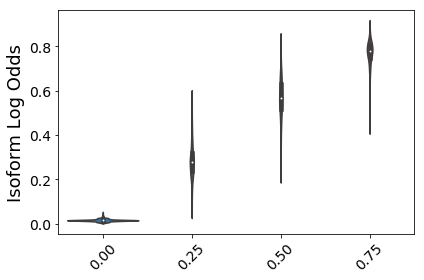

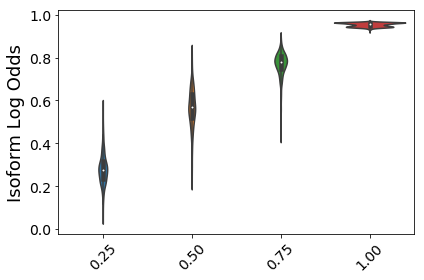

In [45]:

save_figs = False

#Target vs. Engineered Isoform Log Odds

nn_iso_clipped = np.clip(nn_iso_50, 0.001, 0.999)

nn_iso_by_class = [np.ravel(nn_iso_clipped)[flat_labels == lab] for lab in class_targs]
nn_logodds_by_class = [np.log(nn_iso_by_class[k] / (1.0 - nn_iso_by_class[k])) for k in range(len(nn_iso_by_class))]

f = plt.figure(figsize=(6, 4))

sns.violinplot(data=nn_iso_by_class[:4], axis=0)

#plt.xticks(np.arange(5), ['0.05', '0.25', '0.50', '0.75', '1.00'], fontsize=14, rotation=45)
plt.xticks(np.arange(4), ['0.00', '0.25', '0.50', '0.75'], fontsize=14, rotation=45)
plt.yticks(fontsize=14)

plt.ylabel('Isoform Log Odds', fontsize=18)

plt.tight_layout()

if save_figs :
    plt.savefig('splicing_target_isoform_genesis_nn_50_iso_magnitude.png', transparent=True, dpi=150)
    plt.savefig('splicing_target_isoform_genesis_nn_50_iso_magnitude.eps')
    plt.savefig('splicing_target_isoform_genesis_nn_50_iso_magnitude.svg')

plt.show()


f = plt.figure(figsize=(6, 4))

sns.violinplot(data=nn_iso_by_class[1:], axis=0)

plt.xticks(np.arange(4), ['0.25', '0.50', '0.75', '1.00'], fontsize=14, rotation=45)
plt.yticks(fontsize=14)

plt.ylabel('Isoform Log Odds', fontsize=18)

plt.tight_layout()

if save_figs :
    plt.savefig('splicing_max_isoform_genesis_nn_50_iso_magnitude.png', transparent=True, dpi=150)
    plt.savefig('splicing_max_isoform_genesis_nn_50_iso_magnitude.eps')
    plt.savefig('splicing_max_isoform_genesis_nn_50_iso_magnitude.svg')

plt.show()


In [47]:
#Load GENESIS models and predict sample sequences

model_names = [
    'genesis_splicing_cnn_target_isoform_00_pwm_and_multisample_hek_only_random_regions_50_epochs_harderentropy',
    'genesis_splicing_cnn_target_isoform_025_pwm_and_multisample_hek_only_random_regions_50_epochs_harderentropy',
    'genesis_splicing_cnn_target_isoform_05_pwm_and_multisample_hek_only_random_regions_50_epochs_harderentropy',
    'genesis_splicing_cnn_target_isoform_075_pwm_and_multisample_hek_only_random_regions_50_epochs_harderentropy',
    'genesis_splicing_cnn_target_isoform_10_pwm_and_multisample_hek_only_random_regions_70_epochs_harderentropy',
]

sequence_templates = [
    'AGGTGCTTGGNNNNNNNNNNNNNNNNNNNNNNNNNGGTCGACCCAGGTTCGTGNNNNNNNNNNNNNNNNNNNNNNNNNGAGGTATTCTTATCACCTTCGTGGCTACAGA',
    'AGGTGCTTGGNNNNNNNNNNNNNNNNNNNNNNNNNGGTCGACCCAGGTTCGTGNNNNNNNNNNNNNNNNNNNNNNNNNGAGGTATTCTTATCACCTTCGTGGCTACAGA',
    'AGGTGCTTGGNNNNNNNNNNNNNNNNNNNNNNNNNGGTCGACCCAGGTTCGTGNNNNNNNNNNNNNNNNNNNNNNNNNGAGGTATTCTTATCACCTTCGTGGCTACAGA',
    'AGGTGCTTGGNNNNNNNNNNNNNNNNNNNNNNNNNGGTCGACCCAGGTTCGTGNNNNNNNNNNNNNNNNNNNNNNNNNGAGGTATTCTTATCACCTTCGTGGCTACAGA',
    'AGGTGCTTGGNNNNNNNNNNNNNNNNNNNNNNNNNGGTCGACCCAGGTTCGTGNNNNNNNNNNNNNNNNNNNNNNNNNGAGGTATTCTTATCACCTTCGTGGCTACAGA'
]

library_contexts = [
    'n/a',
    'n/a',
    'n/a',
    'n/a',
    'n/a'
]

target_isos = [
    0.00,
    0.25,
    0.5,
    0.75,
    1.0
]

flat_pwms_collection = []

for class_i in range(len(sequence_templates)) :
    print("Target iso = " + str(target_isos[class_i]))
    
    save_dir = os.path.join(os.getcwd(), 'saved_models')
    model_name = model_names[class_i] + '_predictor.h5'
    model_path = os.path.join(save_dir, model_name)

    predictor = load_model(model_path, custom_objects={'st_sampled_softmax': st_sampled_softmax, 'st_hardmax_softmax': st_hardmax_softmax})
    
    n = 32

    sequence_class = np.array(([0] * n)).reshape(-1, 1)

    noise_1 = np.random.uniform(-1, 1, (n, 100))
    noise_2 = np.random.uniform(-1, 1, (n, 100))

    pred_outputs = predictor.predict([sequence_class, noise_1, noise_2], batch_size=32)

    _, _, _, optimized_pwm, _, _, _, _, _, _, _, _, _ = pred_outputs


    pwms = optimized_pwm[:, :, :, 0]

    flat_pwms = np.zeros((n, 109))
    for i in range(n) :
        for j in range(109) :
            max_nt_ix = np.argmax(pwms[i, j, :])

            flat_pwms[i, j] = max_nt_ix + 1


    flat_pwms = flat_pwms[:20, 0: 85]

    print(flat_pwms.shape)
    
    flat_pwms_collection.append(flat_pwms)


flat_pwms = np.concatenate(flat_pwms_collection[::-1], axis=0)

Target iso = 0.0


/home/johli/anaconda3/envs/aparent/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


(20, 85)
Target iso = 0.25


/home/johli/anaconda3/envs/aparent/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


(20, 85)
Target iso = 0.5


/home/johli/anaconda3/envs/aparent/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


(20, 85)
Target iso = 0.75


/home/johli/anaconda3/envs/aparent/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


(20, 85)
Target iso = 1.0


/home/johli/anaconda3/envs/aparent/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


(20, 85)


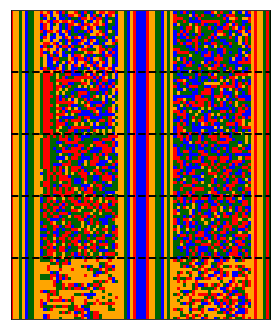

In [50]:
#Plot diversity grid

save_figs = False

cmap = colors.ListedColormap(['red', 'blue', 'orange', 'darkgreen'])
bounds=[0, 1, 2, 3, 4, 5]
norm = colors.BoundaryNorm(bounds, cmap.N)


f = plt.figure(figsize=(4, 12))

plt.imshow(flat_pwms[:100, :], aspect='equal', interpolation='nearest', origin='lower', cmap=cmap, norm=norm)

plt.plot([0, 85], [20, 20], linewidth=2, color='black', linestyle='--')
plt.plot([0, 85], [40, 40], linewidth=2, color='black', linestyle='--')
plt.plot([0, 85], [60, 60], linewidth=2, color='black', linestyle='--')
plt.plot([0, 85], [80, 80], linewidth=2, color='black', linestyle='--')

plt.xticks([], [])
plt.yticks([], [])

plt.xlim(0, 84)
plt.ylim(0, 100)

plt.tight_layout()

if save_figs :
    plt.savefig('splicing_genesis_target_isoform_image_seqs.png', transparent=True, dpi=150)
    plt.savefig('splicing_genesis_target_isoform_image_seqs.svg')
    plt.savefig('splicing_genesis_target_isoform_image_seqs.eps')

plt.show()